In [1]:
print("Jupyter is ready for CE40248")

Jupyter is ready for CE40248


Input -> Calculate forces and integrate equations of motion -> perform P, control T if necessary -> t = t + deltT -> Calculate and update the molecule position (-> t<tmax back to the calcualte forces tab) -> Output: key output is a trajectory file with positions at a given time, here the thermodynamics and transport properties are determined....

Sigma is the diameter of atom and epsilon is the energy of the particle

In order to control reaction in terms of energy, need to completely isolate the system. This is not physically 100% possible. Come with a theoretical limit. 

If try to determine a parameter, do not use the equilibration zone



CE40248 Coursework: Molecular Dynamics
Author: Alex Pooley
Date edited: 27/10/2025
Description: Code takes a series of parameters within a system and using the Lennard-Jones potential, calculates force and velocity to create a file of positions in space, for each molecule for each time step.

In [2]:
import numpy as np

def U_LJ(r, sigma, epsilon): 
    # Function to calculate potential energy, using LJ potential.
    U = 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6) # Dimensional U equation
    return U

def F_LJ(r, sigma, epsilon): 
    # Function to calculate force magnitude, using LJ potential.
    F = 24 * epsilon *(2*(sigma/r)**12 - (sigma/r)**6) / r # Dimensional F equation
    return F


In [3]:
# Initial Variables:
# =================================================
# MC Variables
N = 10                    # Number of particles
nsteps = 20000            # Number of integration steps, where dt=0.005tau and tau = sigma*sqrt(mass/epsilon)
dimensionless_dt = 0.005  # Dimensionless time step

# Material Variables
sigma = 1 #3.405 * 10**-10   # Distance at which U is zero [REF]
epsilon = 1 # 1.65 * 10**-21  # Depth of potential well [REF]
mass_atom = 1 # 6.63e-26      # Mass of one Aargon atom [kg] [REF]
kB = 1

# Initial Calculations
L = 5.0 * sigma                            # Box length, DOES THIS NEED TO BE REDUCED?
tau = sigma * np.sqrt(mass_atom / epsilon) # Tau calculation
dt = dimensionless_dt * tau                # Dimensional time step [s]
rc = 2.5 * sigma # Reduced cutoff (no tail corrections), take as theres no interactions when th distance between the particles is this long

# Set random positions within the box 
np.random.seed(1) # Sets a random seed up
positions = np.random.rand(N, 3) * L # Random initial positions, and then scaled by L to fit in the box (10 x 3 matrix)
velocities = np.random.randn(N, 3) # random velocities (normal distribution)
velocities -= velocities.mean(axis=0) # remove centre-of-mass drift

In [4]:
def compute_forces(positions, rc, sigma, epsilon): 
    # Function to determine the forces acting on each moleucle due to each 
    # interaction, if within distance applicable to LJ.
    
    N = positions.shape[0]            # Gets number of particles from the positions array
    forces = np.zeros_like(positions) # Makes a matrix the same size as positions for forces in each direction
    potential = 0.0                   # Set the potential energy to zero

    # Following loop takes into account every interaction possible. i and j represent a different particle every loop
    for i in range(N - 1): # One less that the total number of particles (as each particle cannot interact with itself)
        
        for j in range(i + 1, N): # For particle i, work interaction to every other particle
            rij = positions[i] - positions[j] # Distance between the compared particles (vector)
            r = np.linalg.norm(rij)           # Finds the magnitude of the distance (Euclidian distance)
    
            if r < 1e-12: # Skip self/near-zero distances to avoid division by zero
                continue
            
            if r < rc: # If below the cut of radius, the molecules will interact
                fij_mag = F_LJ(r, sigma, epsilon)    # Calls LJ force function (magnitude) 
                fij_vec = fij_mag * (rij / r)        # Takes the magnitude of the forces and applies to all directions
                forces[i] += fij_vec                 # Adds the force vector to I
                forces[j] -= fij_vec                 # Subtracts the force vector from j as moves in opposite direction
                potential += U_LJ(r, sigma, epsilon) # Calls LJ potential energy function and adds 
    
    return forces, potential # Contains xyz forces for all particles and summed potential energy


In [5]:
import matplotlib.pyplot as plt

forces, pot = compute_forces(positions, rc, sigma, epsilon) # Initialise the forces and U before alogrithm

KE, PE, TE = [], [], [] # Lists to store energies
save_stride = 10        # Only saves every 10th frame to reduce file size
traj = []               # list of snapshots for XYZ export

for step in range(nsteps): # Will run for number of step initialised earlier
    
    # Velocity-Verlet algorithm 
    velocities += 0.5 * (forces/mass_atom) * dt                 # Originally the random value, F = ma rearrangement
    positions += velocities * dt                                # Then update positions accordingly due to timestep
    forces, pot = compute_forces(positions, rc, sigma, epsilon) # Call the forces function, now with new positions
    velocities += 0.5 * (forces/mass_atom) * dt                 # As above...
   
    kin = 0.5 * mass_atom * np.sum(velocities**2)        # From basic kinetic equation, take into account all particles
    Tinst_history = []
    Tinst = (2 * kin) / (3 * N * kB) 
    print(Tinst) # Calculate the instantaneous temperature 
    Tinst_history.append(Tinst)                          # Add the inst temps to list for analysis
    KE.append(kin); PE.append(pot); TE.append(kin + pot) # Add on the newly calculates parameters
    
    # Rescale velocities to target temperature
    T = 1                              # Target temperature for system to reach
    if step % 5 == 0:
        thermostat_scaler = np.sqrt(T / Tinst) # Make a scaling coefficient for velocity
        velocities *= thermostat_scaler        # Scale the velocity to conserve temperature
    
    if step % save_stride == 0:       # If step is a multiple of the save_stride (10)
        traj.append(positions.copy()) # Only saves if mulitple of 10

55.75450334061317
1.1650670596902029
1.2871352796140867
1.3826162663478447
1.4571516063583219
1.5126607930996026
1.032921224047323
1.0566511733085733
1.0723677627201702
1.0816536250360875
1.0860961618699585
1.0009894840543323
0.9997825160510546
0.9971343578958479
0.9936080188338131
0.9896109051247833
0.9957976079186246
0.9916104490926091
0.9875728955709111
0.9837717232616232
0.9802601624635493
0.9967773763176846
0.9938944447034265
0.9913545843306725
0.9891540007438767
0.9872844339967113
0.9984414768707295
0.9971945048931626
0.9962462278309447
0.9955838856439697
0.9951960056920431
0.9998749637533021
1.0000021587093173
1.0003713195118895
1.0009728801568147
1.0017978858164958
1.0010389858923738
1.0022845284813395
1.003728732993454
1.0053637234557433
1.0071814578265272
1.0019847785468514
1.0041340208963838
1.0064470706909554
1.008913219864114
1.0115116448684502
1.0027427055196771
1.005626555320635
1.0085916495207263
1.0116208041420822
1.0146948875806692
1.0030757096162988
1.006165067173918

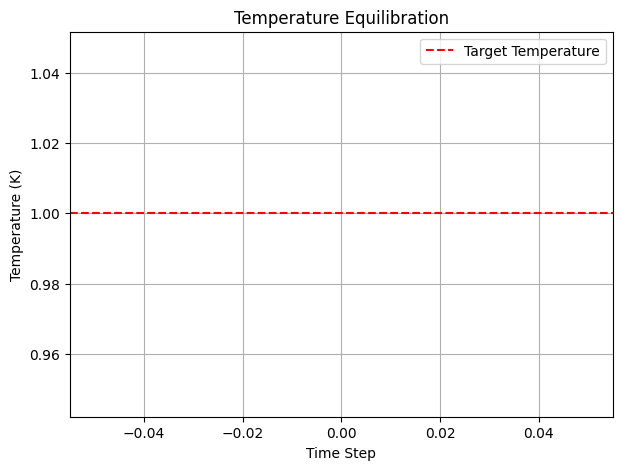

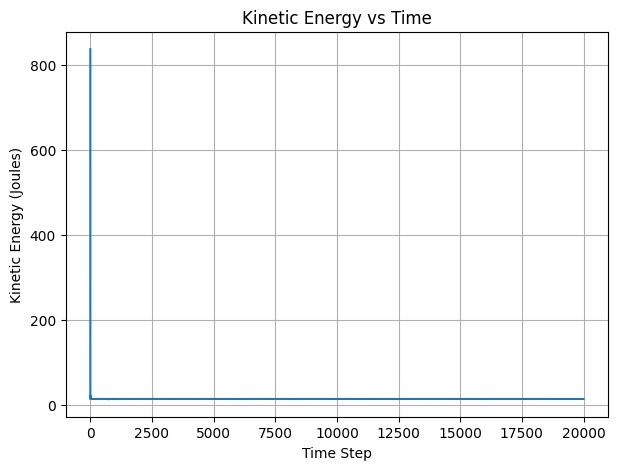

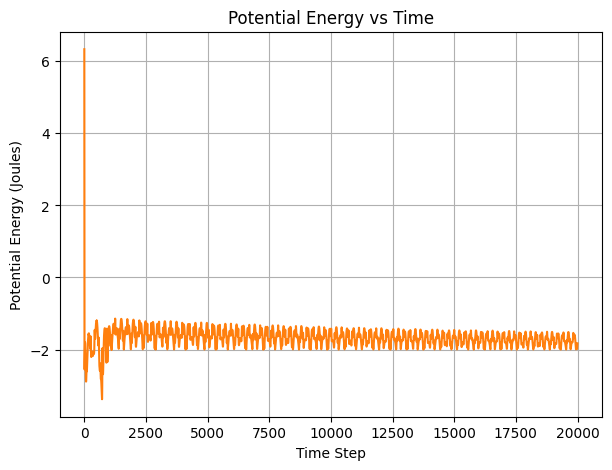

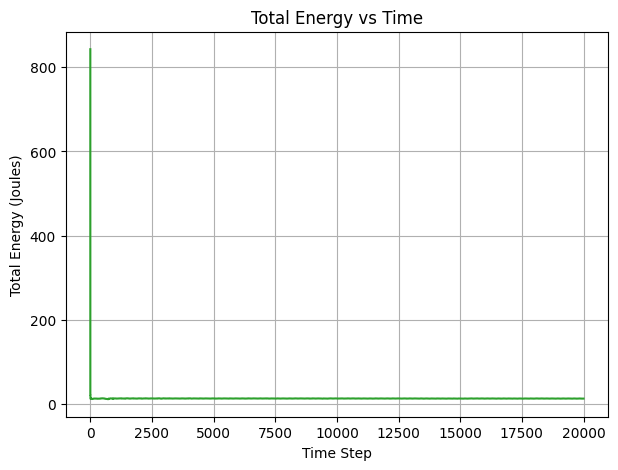

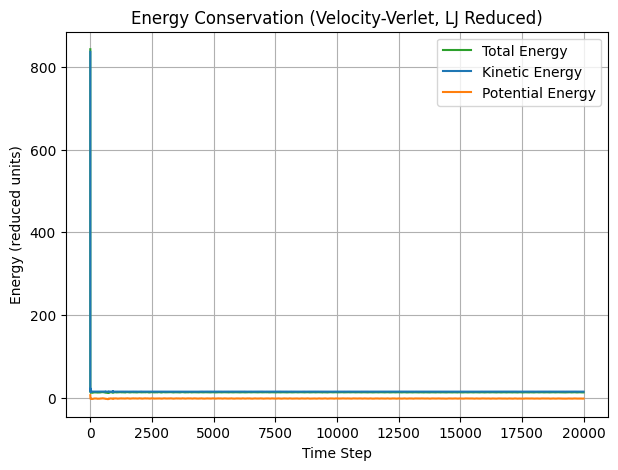

In [6]:
# Plotting energies:
# =============================================

# Plot the temperature
plt.figure(figsize=(7, 5))
plt.plot(Tinst_history)
plt.axhline(T, color='r', linestyle='--', label='Target Temperature')
plt.xlabel('Time Step')
plt.ylabel('Temperature (K)')
plt.title('Temperature Equilibration')
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot 1: Kinetic Energy ----
plt.figure(figsize=(7, 5))
plt.plot(KE, color='tab:blue')
plt.xlabel('Time Step')
plt.ylabel('Kinetic Energy (Joules)')
plt.title('Kinetic Energy vs Time')
plt.grid(True)
plt.show()

# ---- Plot 2: Potential Energy ----
plt.figure(figsize=(7, 5))
plt.plot(PE, color='tab:orange')
plt.xlabel('Time Step')
plt.ylabel('Potential Energy (Joules)')
plt.title('Potential Energy vs Time')
plt.grid(True)
plt.show()

# ---- Plot 3: Total Energy ----
plt.figure(figsize=(7, 5))
plt.plot(TE, color='tab:green')
plt.xlabel('Time Step')
plt.ylabel('Total Energy (Joules)')
plt.title('Total Energy vs Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(TE, label='Total Energy', color='tab:green')
plt.plot(KE, label='Kinetic Energy', color='tab:blue')
plt.plot(PE, label='Potential Energy', color='tab:orange')
plt.xlabel('Time Step')
plt.ylabel('Energy (reduced units)')
plt.title('Energy Conservation (Velocity-Verlet, LJ Reduced)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
scale_factor = 1e10  # meters → angstroms

with open("traj.xyz", "w") as f: # Open the traj file for writing 
    
    for k, frame in enumerate(traj):                      # Loops over every frame in traj
        step = k * save_stride                            # Recover original simulation step
        f.write(f"{N}\nStep {step} (scaled positions)\n") # Writes xyz header N and step number
        
        for x, y, z in frame: # Loop over every particle in the frame, x is first colum etc...
            x_s, y_s, z_s = x*scale_factor, y*scale_factor, z*scale_factor # Scale down to angstroms
            f.write(f"Ar {x:.6f} {y:.6f} {z:.6f}\n")                 # Writes to the file with the 


===============================================================================
Code below is an in text visualiser, not to be included within the coursework.

In [8]:
# ============================================
# Visualise Particle Dispersion from XYZ file
# using py3Dmol in Jupyter Notebook
# ============================================

# Step 1: Install py3Dmol if needed
!pip install py3Dmol

# Step 2: Import and load your .xyz file
import py3Dmol

# Replace this with your file name
filename = "traj.xyz"

with open(filename) as f:
    xyz_data = f.read()

# Step 3: Create viewer
view = py3Dmol.view(width=700, height=500)

# Add all XYZ frames as animation frames
view.addModelsAsFrames(xyz_data, 'xyz')

# Step 4: Style options
view.setStyle({'sphere': {'scale': 0.5, 'colorscheme': 'Jmol'}})  # spheres for particles
view.setBackgroundColor('white')
view.zoomTo()

# Step 5: Animation controls
# Adjust 'step' for speed; smaller = slower animation
view.animate({'loop': 'forward', 'reps': 0, 'step': 1})

# Step 6: Optional — draw a box to represent the simulation boundary
# If your XYZ doesn’t specify box dimensions, set them manually:
box_size = 10.0  # edit this to match your system dimensions

# Draw edges of a cubic box for context
edges = [
    [[0,0,0],[box_size,0,0]], [[0,0,0],[0,box_size,0]], [[0,0,0],[0,0,box_size]],
    [[box_size,box_size,0],[box_size,0,0]], [[box_size,box_size,0],[0,box_size,0]],
    [[box_size,0,box_size],[box_size,0,0]], [[box_size,0,box_size],[0,0,box_size]],
    [[0,box_size,box_size],[0,box_size,0]], [[0,box_size,box_size],[0,0,box_size]],
    [[box_size,box_size,box_size],[box_size,box_size,0]],
    [[box_size,box_size,box_size],[box_size,0,box_size]],
    [[box_size,box_size,box_size],[0,box_size,box_size]]
]

for edge in edges:
    view.addLine({'start': {'x': edge[0][0], 'y': edge[0][1], 'z': edge[0][2]},
                  'end': {'x': edge[1][0], 'y': edge[1][1], 'z': edge[1][2]},
                  'color': 'black', 'radius': 0.05})

view.show()


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\alexj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


3Dmol.js failed to load for some reason. Please check your browser console for error messages.